In [1]:
import numpy as np
import torch
import pandas as pd

import seaborn as sns
sns.set(rc={'figure.figsize':(8,8)})

In [2]:
df = pd.read_csv("ovarian.csv")
df

,tyears,d,Karn,Broders,FIGO,Ascites,Diam,id
0,0.967124,1,9,unknown,IV,present,1-2cm,1
1,2.665753,1,10,4,IV,present,<1cm,2
2,1.054794,1,10,3,III,present,1-2cm,3
3,0.682193,1,9,2,III,present,>5cm,4
4,4.720549,1,10,2,III,unknown,>5cm,5
...,...,...,...,...,...,...,...,...
353,0.131509,1,9,3,III,present,>5cm,354
354,4.169864,0,10,2,III,unknown,<1cm,355
355,4.183561,0,9,2,IV,present,>5cm,356
356,4.164384,0,10,4,III,present,>5cm,357


In [3]:
pd.unique(df.groupby("id").agg({'id':'count'})['id'])

array([1])

In [4]:
df.replace({"unknown":pd.NA}, inplace=True)

In [5]:
df.sort_values(["tyears","id"], ascending=True, inplace=True)
df.reset_index(drop=True, inplace=True)

<AxesSubplot:>

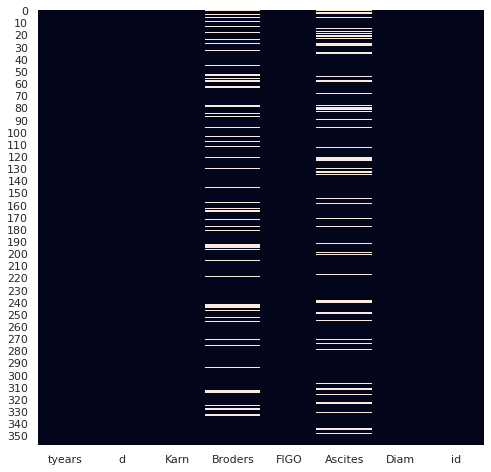

In [6]:
sns.heatmap(df.isnull(), cbar=False)

In [7]:
df[df['Karn'].isnull()]

,tyears,d,Karn,Broders,FIGO,Ascites,Diam,id


In [8]:
df[df.duplicated(subset=['tyears','d'])]

,tyears,d,Karn,Broders,FIGO,Ascites,Diam,id


In [9]:
if (df.duplicated(subset=['tyears','d'])).sum() > 0:
    sns.heatmap(df[df.duplicated(subset=['tyears','d'])], cbar=False)

In [10]:
df[df.duplicated(subset=['tyears'])]

,tyears,d,Karn,Broders,FIGO,Ascites,Diam,id


In [11]:
#df = df[~df.duplicated(subset=['tyears','d'])].copy()

In conversion to torch Tensors from_numpy() preserves precision (to Long type in torch) and then there are no ties in the data, but then torch.einsum() in the loss function will fail as it expects float type.  

However when converting to float type precisition is lost and then there is a tie in two entries: the ones at positions 28 and 29 in Python, or 29 and 30 (0 indexing vs 1 indexing) after sorting entries by increasing tyears.  
To avoid complications from ties, first drop these and try to get agreement with R.

In [12]:
df.iloc[[28,29],:]

,tyears,d,Karn,Broders,FIGO,Ascites,Diam,id
28,0.356164,1,10,2,IV,<NA>,>5cm,25
29,0.356164,1,8,2,III,<NA>,>5cm,130


In [13]:
ties_mask = df.index.isin([28,29])
df[ties_mask]

df = df[~ties_mask]

In [14]:
pd.unique(df.Ascites)

array([<NA>, 'present', 'absent'], dtype=object)

In [15]:
df.loc[:, 'Ascites'] = df.Ascites.replace({'present':1, 'absent':0})

/usr/local/lib/python3.8/dist-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


In [16]:
df.Ascites.describe()

count     306
unique      2
top         1
freq      212
Name: Ascites, dtype: int64

In [17]:
df.dropna(subset=['tyears','d','Karn','Ascites'], inplace=True)

<ipython-input-17-a340c44d636e>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.dropna(subset=['tyears','d','Karn','Ascites'], inplace=True)


In [18]:
df.loc[:, 'Ascites'] = df.Ascites.astype(int)

/usr/local/lib/python3.8/dist-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


In [19]:
ties_mask2 = df.index.isin([304,305])
df[ties_mask2]

df = df[~ties_mask2]

In [20]:
from torch import nn
from torch import optim

tname = 'tyears'
Xnames = ['Karn', 'Ascites']
dname = 'd'

beta = nn.Parameter(torch.zeros(df[Xnames].shape[1])).float()

In [21]:
t = torch.from_numpy(df[tname].values).float()
X = torch.from_numpy(df[Xnames].values).float()
d = torch.from_numpy(df[dname].values).float()

In [22]:
torch.unique(t).shape[0]

304

In [23]:
t.shape[0]

304

In [24]:
torch.unique(t).shape[0] == t.shape[0]

True

In [25]:
uniqt, uniqt_cnt = torch.unique(t, return_counts=True)
uniqt[uniqt_cnt > 1]

tensor([])

For explanation of Cox likelihood see page 127 (page 142 in PDF) of this text:  
http://references.tomhsiung.com/Medical%20Statistics/Survival%20Analysis%20-%20A%20Self-learning%20Text%203E.pdf

Example of how to code up loss optimisation in PyTorch, towards the end of these slides:  
https://github.com/mlelarge/dataflowr-slides/blob/master/Slides/02_neural_nets_dldiy/pres.pdf

For discussion on different ways to handle ties in event time, see page 15 here:  
http://www-personal.umich.edu/~yili/lect4notes.pdf

In [26]:
def get_loss(t, X, d, beta):
    
    tevents = torch.unique(t[d == 1])
    
    loss = 0
    for time in tevents:
                
        Xcurrevent = X[t == time]
        Xatrisk = X[t >= time]
                
        multiplicity = 1
        
        #If there are ties, apply Breslow correction, see slide 15 here:
        #http://www-personal.umich.edu/~yili/lect4notes.pdf
        if Xcurrevent.shape[0]>1:
            multiplicity = Xcurrevent.shape[0]
            #print("TIE observed, multiplicity: {}".format(multiplicity))
            Xcurrevent = torch.reshape(Xcurrevent[0,:], (1, len(beta)))
        
        loss += torch.einsum('j,ij->i', beta, Xcurrevent) #torch.dot(beta, Xcurrevent)
        loss += -multiplicity*torch.log(torch.sum(torch.exp(torch.einsum('j,ij->i', beta, Xatrisk))))
    
    return -loss

In [27]:
get_loss(t, X, d, beta)

tensor([1160.4219], grad_fn=<NegBackward>)

In [28]:
%%time

optimizer = optim.LBFGS([beta], lr=0.1, max_iter=1e3)
#optimizer = optim.SGD([beta], lr=0.001)
#optimizer = optim.RMSprop([beta], lr=0.001)


def closure():
    optimizer.zero_grad()
    loss = get_loss(t, X, d, beta)
    loss.backward()
    return loss

optimizer.step(closure)

betas = beta.detach().numpy()
betas

CPU times: user 3.99 s, sys: 10.7 ms, total: 4 s
Wall time: 4 s


array([-0.23625141,  0.41612804], dtype=float32)

In [29]:
#sudo pip3 install rpy2
%load_ext rpy2.ipython

In [30]:
%%R
library(readr)
library(survival)
library(dplyr)
library(tidyr)

df2 = read_csv("ovarian.csv")
df2 %>% arrange(tyears) %>% slice(c(29,30,305,306))

R[write to console]: 
Attaching package: ‘dplyr’


R[write to console]: The following objects are masked from ‘package:stats’:

    filter, lag


R[write to console]: The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


R[write to console]: Parsed with column specification:
cols(
  tyears = col_double(),
  d = col_double(),
  Karn = col_double(),
  Broders = col_character(),
  FIGO = col_character(),
  Ascites = col_character(),
  Diam = col_character(),
  id = col_double()
)



# A tibble: 4 x 8
  tyears     d  Karn Broders FIGO  Ascites Diam     id
   <dbl> <dbl> <dbl> <chr>   <chr> <chr>   <chr> <dbl>
1  0.356     1    10 2       IV    unknown >5cm     25
2  0.356     1     8 2       III   unknown >5cm    130
3  5.26      1     9 2       III   absent  <1cm    165
4  5.26      0     9 1       III   absent  >5cm    221


In [31]:
%%R

df2 = df2 %>% arrange(tyears) %>% slice(c(-29,-30,-305,-306))

df2 = df2 %>% mutate(Ascites = case_when(Ascites=='unknown'~NA_real_,
                                  Ascites=='present'~1,
                                  Ascites=='absent'~0))

df2 = df2 %>% drop_na(tyears,d,Karn,Ascites)


starttime = Sys.time()

rmod = coxph(Surv(tyears, d) ~ Karn + Ascites, df2, ties="breslow")
print(coef(rmod))

endtime = Sys.time()

print(endtime-starttime)

      Karn    Ascites 
-0.2364006  0.4170308 
Time difference of 0.01910925 secs


Compute second derivative of likelihood to get confidence intervals?  
https://discuss.pytorch.org/t/how-to-calculate-2nd-derivative-of-a-likelihood-function/15085/8  

https://personal.psu.edu/abs12/stat504/Lecture/lec3_4up.pdf

from torch.autograd import grad

loss = get_loss(t, X, d)

loss_grads = grad(loss, beta, create_graph=True)

# compute the second order derivative w.r.t. each parameter
d2loss = []
for idx, param, grd in zip(range(beta.shape[0]), beta, loss_grads):
    #print(idx, param, grd)
    drv = grad(grd, param, create_graph=True)
    d2loss.append(drv)
    print(param, drv)

#for param, grd in zip(beta, loss_grads):
#    print(param)
#    for idx,_ in enumerate(beta):
#        print(grd)
#        drv = grad(grd[idx], param[idx], create_graph=True)
#        d2loss.append(drv)
#    print(param, drv)

In [32]:
def baselineHazard(df, betas, Xnames, tname):
    """Compute the baseline hazard using the Breslow estimator for it."""
    
    t = np.sort(df[tname].values)
    t_uniq = np.unique(t)
    
    h0 = []
    for time in t_uniq:
        
        value = 1/np.sum(np.exp(np.dot(df.loc[df[tname] >= time, Xnames].values, betas)))
        h0.append({'time':time, 'h0':value})

    return pd.DataFrame(h0)

In [33]:
baselineHazard(df, betas, Xnames, tname)

,time,h0
0,0.024657,0.018757
1,0.027398,0.018838
2,0.035617,0.018969
3,0.041094,0.019052
4,0.082192,0.019122
...,...,...
299,7.060274,1.443338
300,7.112330,1.670411
301,7.120548,2.193627
302,7.290410,3.636039


In [34]:
%%R

basehaz(rmod, centered=FALSE) %>% rename(cumhaz=hazard) %>% mutate(haz=lead(cumhaz)-cumhaz) %>% select(time, haz)

          time        haz
1   0.02465724 0.01884820
2   0.02739762 0.01897962
3   0.03561696 0.01906246
4   0.04109387 0.01913217
5   0.08219248 0.01923892
6   0.08767131 0.01937587
7   0.11232937 0.01944789
8   0.12328726 0.01958784
9   0.12876654 0.01972982
10  0.13150880 0.01980043
11  0.18082221 0.01987156
12  0.18904309 0.01994319
13  0.20821886 0.02005922
14  0.22739782 0.02015177
15  0.24657466 0.02024519
16  0.26575480 0.02030722
17  0.28493007 0.02045986
18  0.30684943 0.02049930
19  0.30684997 0.02055945
20  0.36438403 0.02063614
21  0.36712414 0.02076039
22  0.37260313 0.02088615
23  0.37808433 0.02096530
24  0.38630286 0.02112803
25  0.40000226 0.02119193
26  0.41917974 0.02129526
27  0.44109518 0.02142760
28  0.45753364 0.02149332
29  0.47945292 0.02157715
30  0.50137037 0.02166164
31  0.50137066 0.02179859
32  0.50959059 0.02184337
33  0.51233045 0.02192996
34  0.51506886 0.02204063
35  0.52328670 0.02215243
36  0.52328814 0.02229567
37  0.52602734 0.02236684
38  0.536986

In [35]:
valdf = pd.DataFrame({'id':['Bob','Sally','James','Ann'], 'time':[1,3,6,10], 'status':[1,1,0,1], 'smoke':[1,0,0,1]})
valdf

,id,time,status,smoke
0,Bob,1,1,1
1,Sally,3,1,0
2,James,6,0,0
3,Ann,10,1,1


Specify model Cox(t,d ~ smoke) for times $t$ and status indicator $d$.  
$L(T, D, X) = \prod_{t_i^e} \frac{h(t_i^e,X_i)}{\sum_{j:\, t_j \geq t_i^e} h(t_j, X_j)}$  

where $t_i^e$ denote event times (i.e. times where $d=1$), and $t_i$ denotes all times (whether event or censored).  

In this way the ratio $\frac{h(t_i^e,X_i)}{\sum_{j:\, t_j \geq t_i} h(t_j, X_j)}$ is the ratio of the hazard for the event observed at time $t_i^e$ divided by the sum of hazards for all subjects at risk at that time (so with $t_j \geq t_i^e$, i.e. have not had an event yet, have not died, so still at risk, including the subject who had an event at that time since that person must have been at risk too, so inequality includes time $t_i^e$).  

We therefore see that for each of the subjects in the data just above the hazard, $h(t, X) = h_0(t)\,\exp(X \beta)$, is:  
- Bob: $h(t, X) = h_0(t)\,\exp(\beta)$
- Sally: $h(t, X) = h_0(t)\,\exp(0)$
- James: $h(t, X) = h_0(t)\,\exp(0)$
- Ann: $h(t, X) = h_0(t)\,\exp(\beta)$

The likelihood for this dataset then has three factors, one for each event time, and in each factor is the hazard of the person who had the event divided by the sum of the hazards of all the people who were still at risk then (including the person who had the event:  
  
$
\begin{align}
L(T, D, X) = &\left[\frac{h_0(t)\exp(\beta)}{h_0(t)\exp(\beta) \,+\, h_0(t)\exp(0) \,+\, h_0(t)\exp(0) \,+\, h_0(t)\exp(\beta)} \right] \\
&\times \left[ \frac{h_0(t)\exp(0)}{h_0(t)\exp(0) \,+\, h_0(t)\exp(0) \,+\, h_0(t)\exp(\beta)} \right] \\
&\times \left[ \frac{h_0(t)\exp(\beta)}{h_0(t)\exp(\beta)} \right]
\end{align}$

Note that the baseline hazard, $h_0(t)$ will always cancel everywhere in the likelihood! We then have:  
  
$\begin{align}
L(T, D, X) &= \left[\frac{\exp(\beta)}{2(1 + \exp(\beta))} \right] \times \left[ \frac{1}{2+ \exp(\beta)} \right] \times 1
\end{align}
$

Take the natural logarithm of this as the logarithm is a monotone transformation and will not change the position of the minimum, but will simplify the computation of the derivative and make the computation more numerically stable. Also we multipy it by $-1$ so that to maximise the likelihood we minimise the quantity below.

$-\ln[L(T,D,X)] = -\beta +\ln[2(1+\exp(\beta)] - \ln[1] + \ln[2+\exp(\beta)]$

Taking the derivative of this wrt $\beta$ gives  
$\begin{align}
-\frac{d}{d\beta} \ln[L(T,D,X)] &= -1 + \frac{d}{d\beta}\ln[(1+\exp(\beta)] + \frac{d}{d\beta}\ln[2+\exp(\beta)] \\
&= -1 + \frac{1}{1+\exp(\beta)}\exp(\beta) + \frac{1}{2+\exp(\beta)}\exp(\beta)
\end{align}$

Setting this equal to zero, $-\frac{d}{d\beta} \ln[L(T,D,X)] = 0$, gives  
$1 = \frac{\exp(\beta)}{1+\exp(\beta)} + \frac{\exp(\beta)}{2+\exp(\beta)}$

So that this is the equation we need to solve for $\beta$ to find the stationary point (hopefully a minimum, but we haven't proven this, or even convexity yet), and this will be the Maximum Likelihood Estimate (MLE) for $\beta$.

This gives $\beta = \ln(2)/2 \approx 0.34657$

In [36]:
tname_val = 'time'
Xnames_val = ['smoke']
dname_val = 'status'

beta_val = nn.Parameter(torch.zeros(valdf[Xnames_val].shape[1])).float()

tval = torch.from_numpy(valdf[tname_val].values).float()
Xval = torch.from_numpy(valdf[Xnames_val].values).float()
dval = torch.from_numpy(valdf[dname_val].values).float()

optimizer_val = optim.LBFGS([beta_val], lr=0.1, max_iter=1e3)

def closure():
    optimizer_val.zero_grad()
    loss_val = get_loss(tval, Xval, dval, beta_val)
    loss_val.backward()
    return loss_val

optimizer_val.step(closure)

betas_val = beta_val.detach().numpy()
betas_val

array([0.34426704], dtype=float32)

In [37]:
from sklearn.base import BaseEstimator
import torch
from torch import nn
from torch import optim


class Torch_Cox(BaseEstimator):
    """Fit a Cox model
    """

    def __init__(self, lr=0.1, random_state=None):
        self.random_state = random_state
        self.lr = lr
        
    def get_loss(t, X, d, beta):
        tevents = torch.unique(t[d == 1])

        loss = 0
        for time in tevents:

            Xcurrevent = X[t == time]
            Xatrisk = X[t >= time]

            multiplicity = 1

            #If there are ties, apply Breslow correction, see slide 15 here:
            #http://www-personal.umich.edu/~yili/lect4notes.pdf
            if Xcurrevent.shape[0]>1:
                multiplicity = Xcurrevent.shape[0]
                #print("TIE observed, multiplicity: {}".format(multiplicity))
                Xcurrevent = torch.reshape(Xcurrevent[0,:], (1, len(beta)))

            loss += torch.einsum('j,ij->i', beta, Xcurrevent) #torch.dot(beta, Xcurrevent)
            loss += -multiplicity*torch.log(torch.sum(torch.exp(torch.einsum('j,ij->i', beta, Xatrisk))))

        return -loss

    # the arguments are ignored anyway, so we make them optional
    def fit(self, df, Xnames=None, tname=None, dname=None):
        #self.random_state_ = check_random_state(self.random_state)
        beta = nn.Parameter(torch.zeros(df[Xnames].shape[1])).float()
        
        t = torch.from_numpy(df[tname].values).float()
        X = torch.from_numpy(df[Xnames].values).float()
        d = torch.from_numpy(df[dname].values).float()
        
        optimizer = optim.LBFGS([beta], lr=self.lr, max_iter=1e3)

        def closure():
            optimizer.zero_grad()
            loss = get_loss(t, X, d, beta)
            loss.backward()
            return loss

        optimizer.step(closure)

        betas = beta.detach().numpy()
        return betas
    #def predict(self, Xtest):
    #    n_samples = X.shape[0]
    #    return self.random_state_.randn(n_samples, n_components)

In [38]:
%%time

coxmod = Torch_Cox()

coxmod.fit(df, Xnames=Xnames, tname=tname, dname=dname)

CPU times: user 3.63 s, sys: 16.6 ms, total: 3.65 s
Wall time: 3.65 s


array([-0.23625141,  0.41612804], dtype=float32)

In [39]:
def padToMatch2d(inputtens, targetshape):
    target = torch.zeros(*targetshape)
    target[:inputtens.shape[0], :inputtens.shape[1]] = inputtens
    return target

In [40]:
testtens1 = torch.randn(6,4)
testtens2 = torch.randn(10,4)

padToMatch2d(testtens1, testtens2.shape)

tensor([[ 0.6802,  1.8365, -2.2071,  1.0345],
        [-1.7236, -0.6068,  0.6372,  0.5996],
        [ 0.3291,  0.4716,  0.2328, -0.1361],
        [-0.2443,  0.8083, -0.0912, -0.0768],
        [-0.2559, -1.0148, -0.6662, -1.9093],
        [ 0.1403, -0.7348, -1.5297, -1.9456],
        [ 0.0000,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000]])

In [41]:
#tevent = torch.unique(t)

tensin = torch.from_numpy(df[[tname,dname,*Xnames]].sort_values(tname).values)

tensin_events = tensin[tensin[:,1]==1,]
tensin_events = torch.unique(tensin_events[:,0])

tensor = torch.stack([padToMatch2d(tensin[tensin[:,0] >= eventtime, :], tensin.shape) for eventtime in tensin_events])

tensor[:3,:,:]

tensor([[[ 0.0247,  1.0000,  8.0000,  1.0000],
         [ 0.0274,  1.0000,  6.0000,  1.0000],
         [ 0.0356,  1.0000,  8.0000,  1.0000],
         ...,
         [ 7.1205,  0.0000,  9.0000,  1.0000],
         [ 7.2904,  0.0000,  9.0000,  1.0000],
         [ 7.4767,  0.0000, 10.0000,  0.0000]],

        [[ 0.0274,  1.0000,  6.0000,  1.0000],
         [ 0.0356,  1.0000,  8.0000,  1.0000],
         [ 0.0411,  1.0000,  7.0000,  0.0000],
         ...,
         [ 7.2904,  0.0000,  9.0000,  1.0000],
         [ 7.4767,  0.0000, 10.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  0.0000]],

        [[ 0.0356,  1.0000,  8.0000,  1.0000],
         [ 0.0411,  1.0000,  7.0000,  0.0000],
         [ 0.0822,  1.0000,  7.0000,  1.0000],
         ...,
         [ 7.4767,  0.0000, 10.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  0.0000]]])

In [42]:
tensor.shape

torch.Size([225, 304, 4])

In [43]:
#[(tensor[slice, :, 0]==tensor[slice,0,0]) & (tensor[slice, :, 1]==1) for slice in range(tensor.shape[0])]

In [44]:
event_tens_idx = torch.stack([(tensor[slice, :, 0]==tensor[slice,0,0]) & (tensor[slice, :, 1]==1) for slice in range(tensor.shape[0])])
event_tens_idx

tensor([[ True, False, False,  ..., False, False, False],
        [ True, False, False,  ..., False, False, False],
        [ True, False, False,  ..., False, False, False],
        ...,
        [ True, False, False,  ..., False, False, False],
        [ True, False, False,  ..., False, False, False],
        [ True, False, False,  ..., False, False, False]])

In [45]:
event_tens = tensor[event_tens_idx]
event_tens[:10,:]

tensor([[0.0247, 1.0000, 8.0000, 1.0000],
        [0.0274, 1.0000, 6.0000, 1.0000],
        [0.0356, 1.0000, 8.0000, 1.0000],
        [0.0411, 1.0000, 7.0000, 0.0000],
        [0.0822, 1.0000, 7.0000, 1.0000],
        [0.0877, 1.0000, 6.0000, 1.0000],
        [0.1123, 1.0000, 7.0000, 0.0000],
        [0.1233, 1.0000, 6.0000, 1.0000],
        [0.1288, 1.0000, 6.0000, 1.0000],
        [0.1315, 1.0000, 9.0000, 1.0000]])

In [46]:
event_tens.shape

torch.Size([225, 4])

In [47]:
%%time

beta_val2 = nn.Parameter(torch.zeros(len(Xnames))).float()

optimizer_val2 = optim.LBFGS([beta_val2], lr=0.1, max_iter=1e3)

def padToMatch2d(inputtens, targetshape):
    target = torch.zeros(*targetshape)
    target[:inputtens.shape[0], :inputtens.shape[1]] = inputtens
    return target

tensin = torch.from_numpy(df[[tname,dname,*Xnames]].sort_values(tname).values)

#Get unique event times
tensin_events = tensin[tensin[:,1]==1,]
tensin_events = torch.unique(tensin_events[:,0])

#For each unique event stack another matrix with event at the top, and all at risk entries below
tensor = torch.stack([padToMatch2d(tensin[tensin[:,0] >= eventtime, :], tensin.shape) for eventtime in tensin_events])

#Split off the entries corresponding to events
event_tens = tensor[:,0,:]
#event_tens_idx = torch.stack([(tensor[slice, :, 0]==tensor[slice,0,0]) & (tensor[slice, :, 1]==1) for slice in range(tensor.shape[0])])
#event_tens = tensor[event_tens_idx]

#Drop time and status columns as no longer required
tensor = tensor[:,:,2:]
#nonzero_mask = torch.abs(tensor).sum(dim=2) != 0
#tensor = tensor[nonzero_mask]

event_tens = event_tens[:,2:]

#print(tensor)


def get_loss2(tensor, event_tens, beta):
    #tevents = torch.unique(t[d == 1])
    
    #i indexes unique event time slices
    #j indexes rows
    #k indexes columns

    #Numerator entries in log loss, for events
    loss_event = torch.einsum('ik,k->i', event_tens, beta)
    #if len(event_tens.shape)==2:
    #    loss_event = torch.einsum('ik,k->i', event_tens, beta)
    #elif len(event_tens.shape)==3:
    #    loss_event = torch.einsum('ijk,k->i', event_tens, beta)
    
    #Denominator entries in log loss, for at-risk entries
    #print(loss_event)
    #print(torch.einsum('ij, j->i', tensor, beta))
    #print(torch.einsum('ijk,k->ij', tensor, beta))
    
    atrisk_XB = torch.exp(torch.einsum('ijk,k->ij', tensor, beta)).clone()
    #atrisk_XB = torch.exp(torch.nonzero(torch.einsum('ijk,k->ij', tensor, beta)).float())
    #print(atrisk_XB.shape)
    
    #Padding zeroes in tensor will turn into 1s with the exp and then skew the sum if not turned into zeroes
    atrisk_XB[atrisk_XB == 1] = 0
    
    #print(atrisk_XB)
    #print(torch.where(atrisk_XB==1., 0, atrisk_XB))
    #atrisk_XB = torch.where(atrisk_XB.type(torch.LongTensor) == 1, 0, atrisk_XB.type(torch.LongTensor)).float()
    loss_atrisk = -torch.log(torch.sum(atrisk_XB, dim=1))
    #print(loss_atrisk)
    #loss_atrisk = -torch.log((torch.where(atrisk_XB.type(torch.LongTensor)==1, 0, atrisk_XB.type(torch.LongTensor)).sum(dim=1).float()))
    #signtens = torch.stack([(tensor[slice, :, 0]==tensor[slice,0,0]) & (tensor[slice, :, 1]==1) for slice in range(tensor.shape[0])])
    #signtens = torch.where(signtens == True, -1, 1)
    #tensor2 = torch.einsum('ij,ijk->ijk', signtens, tensor)
    #tensor2[:, :, :2] = torch.abs(tensor2[:, :, :2]) 
    #print(loss_atrisk.shape)

    loss = torch.sum(loss_event + loss_atrisk)
    #loss = torch.sum(loss_atrisk) + torch.sum(loss_event)
    
    #loss = torch.sum(loss_event.add(loss_atrisk))
    return -loss


def closure():
    optimizer_val2.zero_grad()
    loss_val2 = get_loss2(tensor, event_tens, beta_val2)
    loss_val2.backward()
    return loss_val2

optimizer_val2.step(closure)

betas_val2 = beta_val2.detach().numpy()
betas_val2

CPU times: user 555 ms, sys: 2.59 ms, total: 557 ms
Wall time: 157 ms


array([-0.23535603,  0.41244242], dtype=float32)